In [1]:
from ipynb.fs.full.Introduction import *
from tqdm import tqdm
import time

## Degree Centrality

As a sanity check, we first assess the extent to which GCNs can predict indegree centrality for our SBM dataset.

$$d_{degree}(v_{i}) = \sum_{j\in{}N_{i}^{1}}w_{ij}$$

In the unweighted case, $w_{ij}$ takes on binary values. 

If $\vec{x^{0}}=\vec{1}$, then GraphConv trivially reduces to $d_{degree}$ when $\Theta_{1}^{0}\rightarrow{}0, \Theta^{0}_{2}\rightarrow{}1$ and $\Theta_{1}^{q}\rightarrow{}x, \Theta^{q}_{2}\rightarrow{}0$ for all $q\leq{}l_{max}$: 

$$ x^{1}_{i} = \Theta_{1}^{0}(x_{i}^{0}) + \Theta_{2}^{0}(\sum_{j\in{}N_{i}^{1}}w_{ij}x_{j}^{0})$$
$$ x^{1}_{i} = 0 + \sum_{j\in{}N_{i}^{1}}w_{ij} = d_{degree}(v_{i})$$
$$ x^{2}_{i} = \Theta_{1}^{1}(d_{degree}(v_{i})) + \Theta_{2}^{1}(\sum_{j\in{}N_{i}^{1}}w_{ij}d_{degree}(v_{j}))$$
$$ x^{2}_{i} = d_{degree}(v_{i}) + 0 $$
$$ ... $$

An EdgeConv model can also learn an exact solution, which occurs at $\Theta{}^{q}\rightarrow{}1$ for all $q\leq{}l_{max}$ regardless of $\vec{x^{0}}$:

$$x_{i}^{q} = \sum_{j\in{}N_{i}^{1}}w_{ij}\Theta{}^{l}(x_{i}^{q}||x_{j}^{q}-x_{i}^{q})$$
$$x_{i}^{q} = \sum_{j\in{}N_{i}^{1}}w_{ij} = d_{degree}(v_{i})$$
$$...$$


We analyze weighted-undirected, weighted-directed, and unweighted-undirected cases. Weights are drawn from $U(0,1)$ and mapped onto the existing edges of our dataset; in the directed case, we simply do not symmetrize them. 

Losses/rank displacement are plotted below for one-layer GraphConv and EdgeConv models, which are each trained to minimze $L(\vec{x^{1}},\vec{d}_{degree})$.

### Unweighted, Undirected

In [3]:
num_graphs = 5000
d = []

for _ in range(num_graphs):

    # Get Cluster sizes and connection probabilities
    n = torch.randint(25,50,(5,))
    p = 1/n + (10/n - 1/n) * torch.rand((5,5))
    p = .5 * (p + p.T)

    # Generate SBM
    x,edges = torch.randn((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    # Create TorchGeometric Data object
    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
    # Compute degree centrality
    y = torch_sparse.sum(adj,dim=1)
    
    # Assign as target
    G.y = y
    d[idx] = G
    
train,test = d[:3000],d[3000::]

train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

In [4]:
torch.manual_seed(0)

Graph = GraphConv(1,32,1,1).cuda()
Edge = EdgeConv(1,32,1,1).cuda()

graph_metrics = train_loop(Graph,train_loader,test_loader,100,lr=1e-3)
torch.cuda.empty_cache()
edge_metrics = train_loop(Edge,train_loader,test_loader,100,lr=1e-3)
torch.cuda.empty_cache()

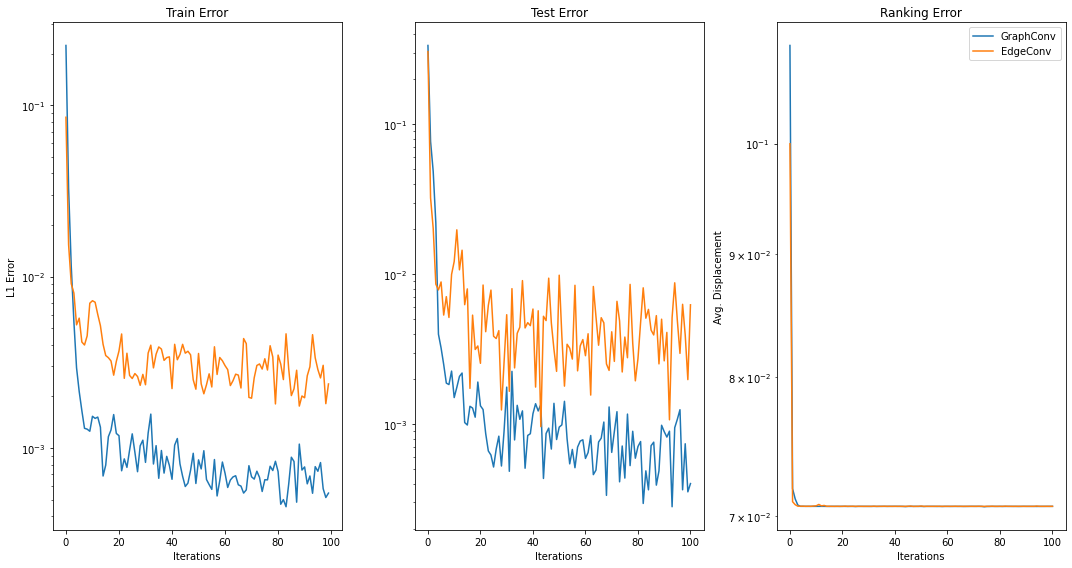

In [5]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(graph_metrics[0])
plt.semilogy(edge_metrics[0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(graph_metrics[1])
plt.semilogy(edge_metrics[1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(graph_metrics[2],label='GraphConv')
plt.semilogy(edge_metrics[2],label='EdgeConv')
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement for GraphConv and EdgeConv on our unweighted, undirected dataset.

### Weighted, Undirected

In [5]:
for idx,G in enumerate(d):

    # Assign weights and symmetrize
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=torch.rand(G.edge_index[0].shape))
    adj = adj.to_dense()
    adj = .5 * (adj + adj.T)
    adj = torch_sparse.SparseTensor.from_dense(adj)
    G.edge_weight = adj.coo()[2]
    
    # Compute degree centrality
    y = torch_sparse.sum(adj,dim=1)
    
    # Assign as target
    G.y = y
    d[idx] = G
    
train,test = d[:2000],d[2000::]

train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

In [6]:
torch.manual_seed(0)

Graph = GraphConv(1,32,1,1).cuda()
Edge = EdgeConv(1,32,1,1).cuda()

graph_metrics = train_loop(Graph,train_loader,test_loader,100,lr=1e-3)
torch.cuda.empty_cache()
edge_metrics = train_loop(Edge,train_loader,test_loader,100,lr=1e-3)
torch.cuda.empty_cache()

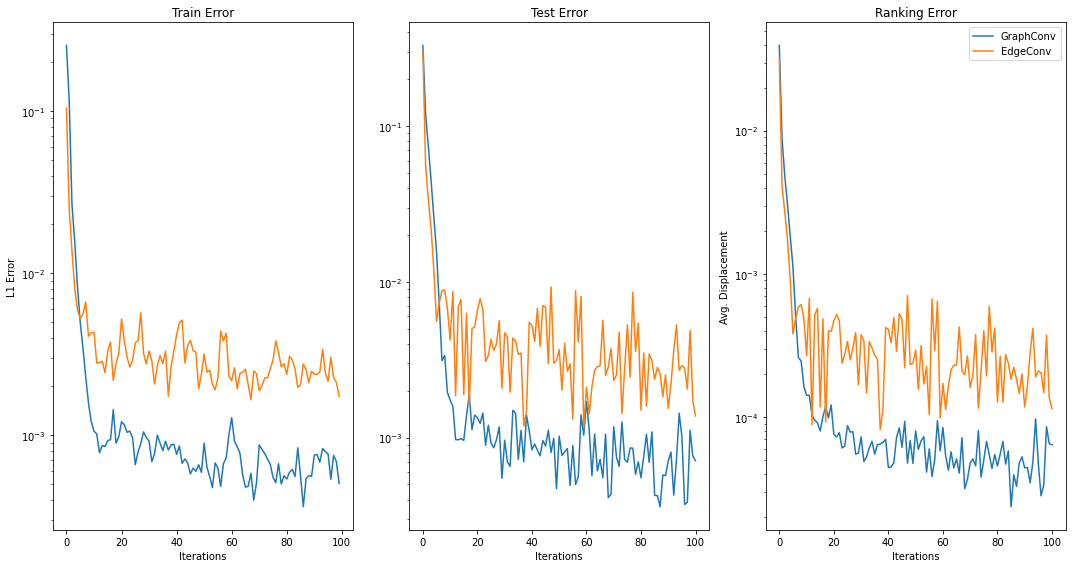

In [7]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(graph_metrics[0])
plt.semilogy(edge_metrics[0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(graph_metrics[1])
plt.semilogy(edge_metrics[1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(graph_metrics[2],label='GraphConv')
plt.semilogy(edge_metrics[2],label='EdgeConv')
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement for GraphConv and EdgeConv on our weighted, undirected dataset.

### Weighted, Directed

In [8]:
for idx,G in enumerate(d):
    
    # Assign weights
    G.edge_weight = torch.rand(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
    # Compute degree centrality
    y = torch_sparse.sum(adj,dim=1)
    
    # Assign as target
    G.y = y
    d[idx] = G
    
train,test = d[:2000],d[2000::]

train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

In [9]:
torch.manual_seed(0)

Graph = GraphConv(1,32,1,1).cuda()
Edge = EdgeConv(1,32,1,1).cuda()

graph_metrics = train_loop(Graph,train_loader,test_loader,100,lr=1e-3)
torch.cuda.empty_cache()
edge_metrics = train_loop(Edge,train_loader,test_loader,100,lr=1e-3)
torch.cuda.empty_cache()

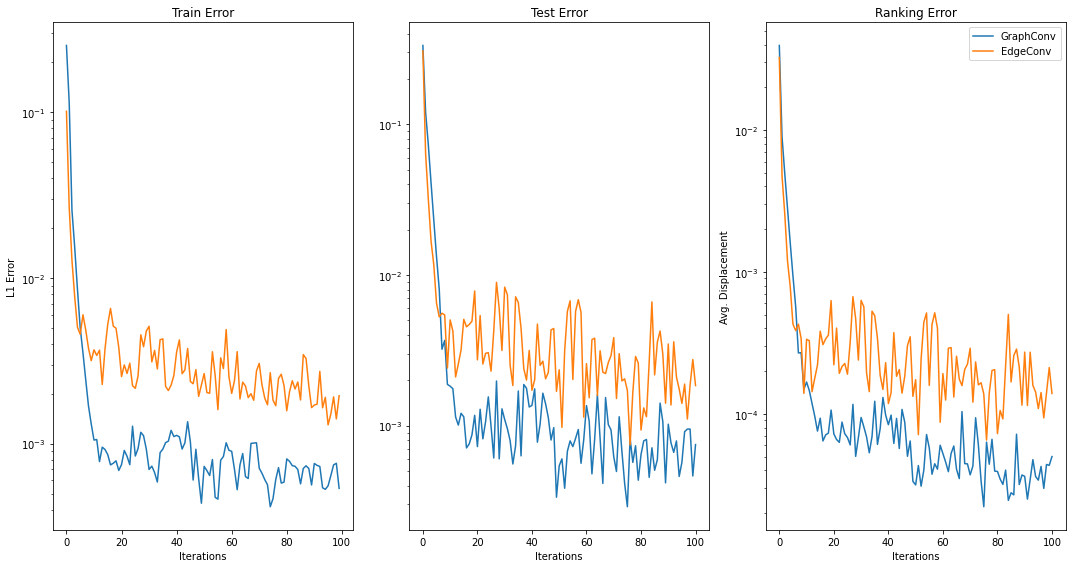

In [10]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(graph_metrics[0])
plt.semilogy(edge_metrics[0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(graph_metrics[1])
plt.semilogy(edge_metrics[1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(graph_metrics[2],label='GraphConv')
plt.semilogy(edge_metrics[2],label='EdgeConv')
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement for GraphConv and EdgeConv on our weighted, directed dataset.

### Overview

GraphConv generally converges to around $7e^{-4}$, with EdgeConv averaging $2e^{-3}$. Seperation is greatest for weighted, directed case, followed by unweighted, undirected. As degree is arguably the simplest centrality measure, we should expect these models to perform no better on more complex centralities. Note: rank displacement is ill-suited to the unweighted, undirected case. There are only a limited number of values which $d_{degree}$ can take on, and few are unique. Hence small perturbations in our predictions have outsized effects on the displacement. 